# cnn with cbow fasttext

##  prepare

In [ ]:
import pandas as pd
import numpy as np
import time

from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from tensorflow.keras import regularizers, optimizers

from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
dataset = "/content/Segmented-Sentiments - Sheet1 (1).csv"

In [ ]:
data = pd.read_csv(dataset)
print(data.head())

   Index                                          Sentences Sentiment
0      0  အန်ဒရီယာ မာစီ သည် အီတလီ အတွက် စမ်းသပ်မှု တစ်ခု...  Positive
1      1  ပေါ်တူဂီ သည် ဘယ်သောအခါမှ စွန့်လွှတ်မှု မရှိခဲ့...  Positive
2      2  အီတလီ သည် ပထမပိုင်း ၌ ၁၆-၅ ဖြင့် ဦးဆောင်ခဲ့ သေ...  Positive
3      3  သို့သော်လည်း ဘော်တိုလပ်စီ သည် မော်ရို ဘာဂမ်မက်...  Positive
4      4  နယူးဇီလန် သည် ရမှတ် ကွာခြားချက် အပေါ် စကော့တလန...  Positive


In [ ]:
data.isnull().sum()

Index        0
Sentences    0
Sentiment    0
dtype: int64

In [ ]:
data = data.loc[data["Sentiment"] != "Neutral"]

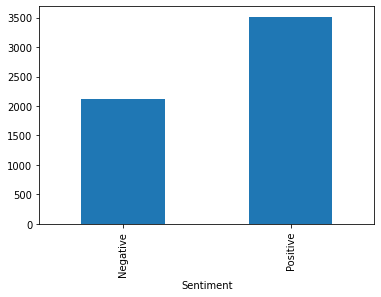

In [ ]:
data['category_id'] = data['Sentiment'].factorize()[0]
colslist = ['Index','Sentence', 'Sentiment', 'category_id']
data.columns = colslist
data.groupby('Sentiment').Index.count().plot.bar(ylim=0)

In [ ]:
stopwordslist = []
slist = []
with open("/content/stopword (1).txt", encoding = 'utf8') as stopwordsfile:
    stopwords = stopwordsfile.readlines()
    slist.extend(stopwords)
    for w in range(len(slist)):
        temp = slist[w]
        stopwordslist.append(temp.rstrip())

In [ ]:
import re
CleanPattern = re.compile(r'\d+|[၊။!-/:-@[-`{-~\t ]|[A-za-z0-9]')
def clean_sentence(sentence):
     sent = CleanPattern.sub(" ",sentence)
     return sent

def stop_word(sentence):
  new_sentence = []
  for word in sentence.split():
    if word not in stopwordslist:
      new_sentence.append(word)
  return(' '.join(new_sentence))

BreakPattern = re.compile(r'(?:(?<!္)([က-ဪဿ၊-၏]|[၀-၉]+|[^က-၏]+)(?![ှျ]?[့္်]))')

def sylbreak(sentence):
    line = BreakPattern.sub(" " + r"\1",sentence)
    return line

def process(sentence):
    line = clean_sentence(sentence)
    sentence = stop_word(line)
    return sentence

data['Sentence'] = data['Sentence'].apply(process)
data.head(10)

,Index,Sentence,Sentiment,category_id
0,0,အန်ဒရီယာ မာစီ အီတလီ စမ်းသပ်မှု တစ်ခု စတုတ္ထ မိ...,Positive,0
1,1,ပေါ်တူဂီ ဘယ်သောအခါမှ စွန့်လွှတ်မှု မရှိခဲ့ ဒေး...,Positive,0
2,2,အီတလီ ပထမပိုင်း ဖြင့် ဦးဆောင်ခဲ့ ပေါ်တူဂီ ဒုတိ...,Positive,0
3,3,သို့သော်လည်း ဘော်တိုလပ်စီ မော်ရို ဘာဂမ်မက်စကို...,Positive,0
4,4,နယူးဇီလန် ရမှတ် ကွာခြားချက် စကော့တလန်၏ ရှေ့မှ ...,Positive,0
5,5,အသေးစိတ်များကို မနေ့က ယူတီစီ အောက်လွှတ်တော် ဗြ...,Positive,0
6,6,လွှတ်တော်အမတ်များ သူမ၏ ကြေငြာချက် ရုသ်ကယ်လီ ပျ...,Positive,0
7,7,သူမသည် လုံခြုံရေးရာ ဆောင်ရွက်မှုများ ရယူခဲ့ကြေ...,Positive,0
8,8,လစ်ဘရယ် ဒီမိုကရက် ကိုယ်စားပြုထားသော ဆူဇန် ကရာမ...,Positive,0
9,9,လူးဝတ် ဆက်လက် မှတ်ချက်ပြုခဲ့သည် င်္သဘော အမှတ်အ...,Positive,0


In [ ]:
import os, re, csv, math, codecs
from tqdm import tqdm

In [ ]:
X = data['Sentence'].fillna('').tolist()
X = [str(i) for i in X]
y = np.array(data['category_id'])

In [ ]:
X[500]

'အနာဂတ် ဆိုသည်မှာ တစ်နှစ် နှစ်နှစ် သုံးနှစ် ဆိုလို'

In [ ]:
RANDOM_STATE = 42

# Split train & test
text_train, text_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Tokenize and transform to integer index
tokenizer = Tokenizer(split=" ")
tokenizer.fit_on_texts(text_train)

X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = max(len(x) for x in X_train) # longest text in train set

# Add pading to ensure all vectors have same dimensionality
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
maxlen

366

In [ ]:
y_train.shape

(4503,)

In [ ]:
y_test.shape

(1126,)

In [ ]:
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

dictionary size:  21207


In [ ]:
maxlen

366

In [ ]:
vocab_size

21208

In [ ]:
#load embeddings
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('/content/fasttext_cbow_myNews_final.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

In [ ]:
#training params
batch_size = 128 
num_epochs = 10

#model parameters
num_filters = 64 
embed_dim = 100 
weight_decay = 0.025

In [ ]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(vocab_size, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 21207


In [ ]:
print("sample words not found: ", np.random.choice(words_not_found, 50))

sample words not found:  ['လူမှုမီဒီယာများတွင်' 'ကုန်သည်' 'ဆက်သအပ်ပါတယ်' 'မှဝန်ထမ်း'
 'တော်လှန်ရေးကောင်စီ' 'စက်အကူအညီ' 'ရသည့်' 'ယဉ်ကျေးမှု' 'တစ်နှစ်ကြာ'
 'ဘတ်ဂျက်' 'ရေးသား၍' 'ပို့ခဲ့သည်' 'အန္တရာယ်တွေ' 'တိုးချဲ့ခြင်း'
 'ကော်မရှင်အဖွဲ့' 'သေအပ်ငွေအတိုး' 'လေးခု' 'မိုးညှင်းမြို့နယ်'
 'အထုတ်အပိုးများ' 'နိုင်ငံတကာပွဲ' 'အမျိုးသမီးကပါ' 'ပေးအပ်ချီးမြှင့်'
 'လိုရာ' 'သဘင်' 'ကိုယ်ထိလက်ရောက်' 'ပြုတ်ကျခြင်း' 'ဆီးနိတ်အမတ်'
 'ရင်ဆိုင်နေရသည်ဟု' 'နစ်မြုပ်မှု' 'ဗြိတိသျှအစိုးရ' 'ဘရီယာ' 'ဩဝါဒများ'
 'ပိတ်ခဲ့သည်' 'မက်ဗွီဒက်' 'ခေါင်းစဉ်တပ်ခဲ့သည်' 'ကုသမှုဟာ' 'လေးလံသော'
 'အလုံးစုံ' 'ကိုငွေကျပ်' 'နေရာယူထား' 'နောက်တဆင့်သို့' 'စက်ခလုတ်' 'အစ်'
 'လစ်ဘရယ်တေးရီရမ်' 'စွမ်းဆောင်မှုများမှာ' 'ဖမ်းဆီးခံခဲ့ရပါသည်' 'ဟက်က'
 'မေးကာ' 'ဝယ်ခဲ့သည်' 'ရင်ဆိုင်နေရသည်ဟု']


## nonStatic

In [ ]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten
from tensorflow import keras
import tensorflow as tf 
#CNN architecture -static
print("training CNN ...")
model = Sequential()
model.add(Embedding(nb_words, embed_dim,weights=[embedding_matrix], input_length=maxlen, trainable=True))
model.add(Dropout(0.2))

model.add(Conv1D(64, 2, activation='relu', padding='same'))
model.add(MaxPooling1D(5))
model.add(Dropout(0.2))

model.add(Conv1D(64, 3, activation='relu', padding='same'))
model.add(MaxPooling1D(5))
model.add(Dropout(0.2))

model.add(Conv1D(64, 5, activation='relu', padding='same'))
model.add(MaxPooling1D(5))
model.add(Dropout(0.2))

model.add(Flatten())
#model.add(Dropout(0.4))
#model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(1, activation='sigmoid'))  

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy",keras.metrics.Precision(),keras.metrics.Recall()])
model.summary()

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, to_file='CNN-Trainable.png')

In [ ]:
from keras.callbacks import EarlyStopping
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]
#model training
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=10, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)

Epoch 1/10
32/32 - 5s - loss: 1.5821 - accuracy: 0.6209 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4063 - val_accuracy: 0.6208 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 5s/epoch - 158ms/step
Epoch 2/10
32/32 - 1s - loss: 1.2790 - accuracy: 0.6209 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.1572 - val_accuracy: 0.6208 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 802ms/epoch - 25ms/step
Epoch 3/10
32/32 - 1s - loss: 1.0704 - accuracy: 0.6209 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.9877 - val_accuracy: 0.6208 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 771ms/epoch - 24ms/step
Epoch 4/10
32/32 - 1s - loss: 0.9294 - accuracy: 0.6209 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.8739 - val_accuracy: 0.6208 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 763ms/epoch - 24ms/step
Epoch 5/10
32/32 - 1s - loss: 0.8352 - accuracy: 0.6209 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0

In [ ]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


In [ ]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
print('Loss', loss)
print('Accuracy', accuracy)
print('Precision', precision)
print('Recall', recall)

f1_score = (2* recall*precision)/(recall+precision)
print("f1_score", f1_score)

Loss 0.674492359161377
Accuracy 0.6358792185783386
Precision 0.0
Recall 0.0


ZeroDivisionError: ignored

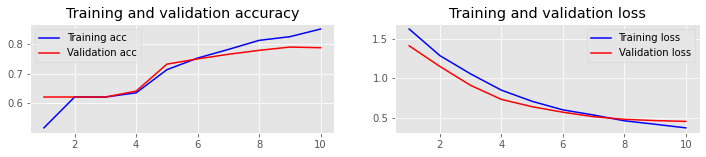

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 2))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(hist)

## static

In [ ]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten
from tensorflow import keras
import tensorflow as tf 
#CNN architecture -static
print("training CNN ...")
model1 = Sequential()
model1.add(Embedding(nb_words, embed_dim,weights=[embedding_matrix], input_length=maxlen, trainable=False))
#model1.add(Dropout(0.2))

model1.add(Conv1D(64, 2, activation='relu', padding='same'))
model1.add(MaxPooling1D(5))
model1.add(Dropout(0.2))

model1.add(Conv1D(64, 3, activation='relu', padding='same'))
model1.add(MaxPooling1D(5))
model1.add(Dropout(0.2))

model1.add(Conv1D(64, 5, activation='relu', padding='same'))
model1.add(MaxPooling1D(5))
model1.add(Dropout(0.2))

model1.add(Flatten())
#model.add(Dropout(0.4))
#model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0.4))
model1.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model1.add(Dense(1, activation='sigmoid'))  

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy",keras.metrics.Precision(),keras.metrics.Recall()])
model1.summary()

training CNN ...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 366, 100)          2120700   
                                                                 
 conv1d_3 (Conv1D)           (None, 366, 64)           12864     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 73, 64)           0         
 1D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 73, 64)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 73, 64)            12352     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 14, 64)           0         
 1D)                                 

In [ ]:
from keras.callbacks import EarlyStopping
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]
#model training
hist1 = model1.fit(X_train, y_train, batch_size=batch_size, epochs=10, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)

Epoch 1/10
32/32 - 2s - loss: 1.5919 - accuracy: 0.6148 - precision_1: 0.4309 - recall_1: 0.0508 - val_loss: 1.3940 - val_accuracy: 0.6208 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - 2s/epoch - 54ms/step
Epoch 2/10
32/32 - 0s - loss: 1.2418 - accuracy: 0.6372 - precision_1: 0.6071 - recall_1: 0.1217 - val_loss: 1.0603 - val_accuracy: 0.7095 - val_precision_1: 0.6250 - val_recall_1: 0.5848 - 274ms/epoch - 9ms/step
Epoch 3/10
32/32 - 0s - loss: 0.9656 - accuracy: 0.7204 - precision_1: 0.6268 - recall_1: 0.6484 - val_loss: 0.8701 - val_accuracy: 0.7273 - val_precision_1: 0.6071 - val_recall_1: 0.7953 - 264ms/epoch - 8ms/step
Epoch 4/10
32/32 - 0s - loss: 0.7992 - accuracy: 0.7448 - precision_1: 0.6441 - recall_1: 0.7305 - val_loss: 0.7367 - val_accuracy: 0.7450 - val_precision_1: 0.6414 - val_recall_1: 0.7427 - 258ms/epoch - 8ms/step
Epoch 5/10
32/32 - 0s - loss: 0.6667 - accuracy: 0.7710 - precision_1: 0.6790 - recall_1: 0.7507 - val_loss: 0.6523 - val_accuracy: 0.7472 - v

In [ ]:
loss, accuracy, precision, recall = model1.evaluate(X_test, y_test, verbose=0)
print('Loss', loss)
print('Accuracy', accuracy)
print('Precision', precision)
print('Recall', recall)

f1_score = (2* recall*precision)/(recall+precision)
print("f1_score", f1_score)

Loss 0.5164514183998108
Accuracy 0.7619893550872803
Precision 0.676616907119751
Recall 0.6634146571159363
f1_score 0.6699507465583034


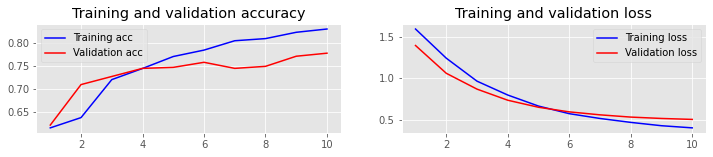

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 2))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(hist1)

## CNN-rand

In [ ]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten
from tensorflow import keras
import tensorflow as tf 
#CNN architecture -static
print("training CNN ...")
model3 = Sequential()
model3.add(Embedding(nb_words, embed_dim, input_length=maxlen, trainable=True))
#model3.add(Dropout(0.2))

model3.add(Conv1D(64, 3, activation='relu', padding='same'))
model3.add(MaxPooling1D(5))
model3.add(Dropout(0.2))

model3.add(Conv1D(64, 3, activation='relu', padding='same'))
model3.add(MaxPooling1D(5))
model3.add(Dropout(0.2))

model3.add(Conv1D(64, 3, activation='relu', padding='same'))
model3.add(MaxPooling1D(5))
model3.add(Dropout(0.2))

model3.add(Flatten())
#model.add(Dropout(0.4))
#model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model3.add(Dense(1, activation='sigmoid'))  

model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy",keras.metrics.Precision(),keras.metrics.Recall()])
model3.summary()

training CNN ...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 366, 100)          2120700   
                                                                 
 conv1d_6 (Conv1D)           (None, 366, 64)           19264     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 73, 64)           0         
 1D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 73, 64)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 73, 64)            12352     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 14, 64)           0         
 1D)                                 

In [ ]:
from keras.callbacks import EarlyStopping
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2, verbose=1)
callbacks_list = [early_stopping]
#model training
hist3 = model3.fit(X_train, y_train, batch_size=batch_size, epochs=5, callbacks=callbacks_list, validation_split=0.2, shuffle=True, verbose=2)

Epoch 1/5
29/29 - 2s - loss: 1.5825 - accuracy: 0.6124 - precision_2: 0.3182 - recall_2: 0.0312 - val_loss: 1.4202 - val_accuracy: 0.6016 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - 2s/epoch - 73ms/step
Epoch 2/5
29/29 - 0s - loss: 1.2931 - accuracy: 0.6258 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 1.1801 - val_accuracy: 0.6016 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - 334ms/epoch - 12ms/step
Epoch 3/5
29/29 - 0s - loss: 1.0566 - accuracy: 0.6258 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.9284 - val_accuracy: 0.6016 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - 330ms/epoch - 11ms/step
Epoch 4/5
29/29 - 0s - loss: 0.7205 - accuracy: 0.7240 - precision_2: 0.8969 - recall_2: 0.2967 - val_loss: 0.7623 - val_accuracy: 0.7392 - val_precision_2: 0.7719 - val_recall_2: 0.4903 - 351ms/epoch - 12ms/step
Epoch 5/5
29/29 - 0s - loss: 0.4918 - accuracy: 0.9525 - precision_2: 0.9482 - recall_2: 0.9236 - val_loss: 0.7

In [ ]:
loss, accuracy, precision, recall = model3.evaluate(X_test, y_test, verbose=0)
print('Loss', loss)
print('Accuracy', accuracy)
print('Precision', precision)
print('Recall', recall)

f1_score = (2* recall*precision)/(recall+precision)
print("f1_score", f1_score)

Loss 0.592464804649353
Accuracy 0.798401415348053
Precision 0.7479674816131592
Recall 0.6731707453727722
f1_score 0.7086007786589645


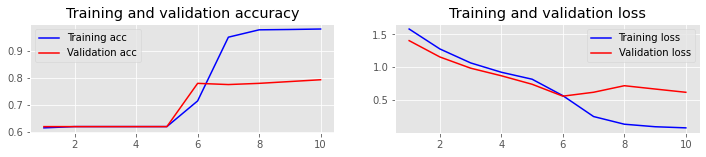

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 2))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(hist3)

## Multi Channel

In [ ]:
import tensorflow as tf 
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding, GlobalMaxPooling1D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate

from tensorflow import keras
import tensorflow as tf 


In [ ]:
from keras.layers import Input

inputs1 = Input(shape=(maxlen,))

# channel 1
embedding1 = Embedding(nb_words, 100, weights=[embedding_matrix],trainable = True)(inputs1)

drop = Dropout(0.2)(embedding1)

conv1 = Conv1D(filters=64, kernel_size=2, activation='relu')(drop)
pool1 = MaxPooling1D(pool_size=5,padding='same')(conv1)
drop1 = Dropout(0.2)(pool1)

conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')(drop1)
pool1 = MaxPooling1D(pool_size=5,padding='same')(conv1)
drop1 = Dropout(0.2)(pool1)

conv1 = Conv1D(filters=64, kernel_size=5, activation='relu')(drop1)
pool1 = MaxPooling1D(pool_size=5,padding='same')(conv1)
drop1 = Dropout(0.2)(pool1)
flat1 = Flatten()(drop1)

In [ ]:
from keras.layers import Input

# channel 2
embedding2 = Embedding(nb_words, 100, weights=[embedding_matrix],trainable = False)(inputs1)

drop = Dropout(0.2)(embedding2)

conv2 = Conv1D(filters=64, kernel_size=2, activation='relu')(drop)
pool2 = MaxPooling1D(pool_size=5,padding='same')(conv2)
drop2 = Dropout(0.2)(pool2)

conv2 = Conv1D(filters=64, kernel_size=3, activation='relu')(drop2)
pool2 = MaxPooling1D(pool_size=5,padding='same')(conv2)
drop2 = Dropout(0.2)(pool2)

conv2 = Conv1D(filters=64, kernel_size=5, activation='relu')(drop2)
pool2 = MaxPooling1D(pool_size=5,padding='same')(conv2)
drop2 = Dropout(0.2)(pool2)
flat2 = Flatten()(drop2)

In [ ]:
merged = concatenate([flat1, flat2])

# interpretation
dense1 = Dense(32, activation='relu')(merged)
drop2 = Dropout(0.4)(dense1)
#dense1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(drop2)
dense2 = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(dense1)
outputs = Dense(1, activation='sigmoid')(dense2)

model3 = Model(inputs=inputs1, outputs=outputs)

# compile
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy",keras.metrics.Precision(),keras.metrics.Recall()])
# summarize
print(model3.summary())

#plot_model(model, show_shapes=True, to_file='multichannel.png')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 366)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 366, 100)     2120700     ['input_1[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 366, 100)     2120700     ['input_1[0][0]']                
                                                                                                  
 dropout_9 (Dropout)            (None, 366, 100)     0           ['embedding_2[0][0]']            
                                                                                              

In [ ]:
from keras.callbacks import EarlyStopping
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]
#model training
hist3 = model3.fit(X_train, y_train, batch_size=batch_size, epochs=10, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)

Epoch 1/10
32/32 - 3s - loss: 1.5134 - accuracy: 0.6335 - precision_2: 0.6308 - recall_2: 0.0801 - val_loss: 1.2646 - val_accuracy: 0.7007 - val_precision_2: 0.6184 - val_recall_2: 0.5497 - 3s/epoch - 98ms/step
Epoch 2/10
32/32 - 1s - loss: 1.1283 - accuracy: 0.7127 - precision_2: 0.6186 - recall_2: 0.6315 - val_loss: 0.9702 - val_accuracy: 0.7384 - val_precision_2: 0.6345 - val_recall_2: 0.7310 - 554ms/epoch - 17ms/step
Epoch 3/10
32/32 - 1s - loss: 0.8866 - accuracy: 0.7606 - precision_2: 0.6649 - recall_2: 0.7428 - val_loss: 0.7988 - val_accuracy: 0.7583 - val_precision_2: 0.6632 - val_recall_2: 0.7368 - 521ms/epoch - 16ms/step
Epoch 4/10
32/32 - 1s - loss: 0.7264 - accuracy: 0.7757 - precision_2: 0.6885 - recall_2: 0.7454 - val_loss: 0.6923 - val_accuracy: 0.7583 - val_precision_2: 0.6422 - val_recall_2: 0.8187 - 518ms/epoch - 16ms/step
Epoch 5/10
32/32 - 1s - loss: 0.6115 - accuracy: 0.7915 - precision_2: 0.7015 - recall_2: 0.7832 - val_loss: 0.6005 - val_accuracy: 0.7561 - val_pr

In [ ]:
loss, accuracy, precision, recall = model3.evaluate(X_test, y_test, verbose=0)
print('Loss', loss)
print('Accuracy', accuracy)
print('Precision', precision)
print('Recall', recall)

f1_score = (2* recall*precision)/(recall+precision)
print("f1_score", f1_score)

Loss 0.5138520002365112
Accuracy 0.7841918468475342
Precision 0.7124682068824768
Recall 0.6829268336296082
f1_score 0.6973848157142


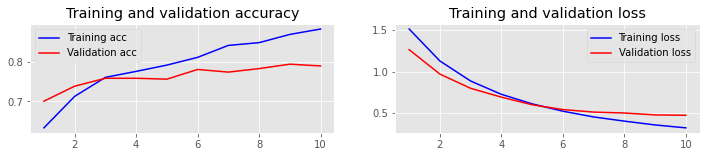

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 2))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(hist3)

# cnn with skipgram fasttext

##  prepare

In [1]:
import pandas as pd
import numpy as np
import time

from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from tensorflow.keras import regularizers, optimizers

from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
dataset = "/content/Segmented-Sentiments - Sheet1 (1).csv"

In [4]:
data = pd.read_csv(dataset)
print(data.head())

   Index                                          Sentences Sentiment
0      0  အန်ဒရီယာ မာစီ သည် အီတလီ အတွက် စမ်းသပ်မှု တစ်ခု...  Positive
1      1  ပေါ်တူဂီ သည် ဘယ်သောအခါမှ စွန့်လွှတ်မှု မရှိခဲ့...  Positive
2      2  အီတလီ သည် ပထမပိုင်း ၌ ၁၆-၅ ဖြင့် ဦးဆောင်ခဲ့ သေ...  Positive
3      3  သို့သော်လည်း ဘော်တိုလပ်စီ သည် မော်ရို ဘာဂမ်မက်...  Positive
4      4  နယူးဇီလန် သည် ရမှတ် ကွာခြားချက် အပေါ် စကော့တလန...  Positive


In [5]:
data.isnull().sum()

Index        0
Sentences    0
Sentiment    0
dtype: int64

In [6]:
data = data.loc[data["Sentiment"] != "Neutral"]

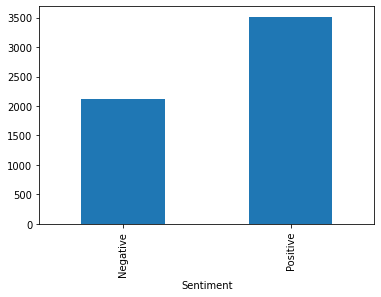

In [7]:
data['category_id'] = data['Sentiment'].factorize()[0]
colslist = ['Index','Sentence', 'Sentiment', 'category_id']
data.columns = colslist
data.groupby('Sentiment').Index.count().plot.bar(ylim=0)

In [8]:
stopwordslist = []
slist = []
with open("/content/stopword (1).txt", encoding = 'utf8') as stopwordsfile:
    stopwords = stopwordsfile.readlines()
    slist.extend(stopwords)
    for w in range(len(slist)):
        temp = slist[w]
        stopwordslist.append(temp.rstrip())

In [9]:
import re
CleanPattern = re.compile(r'\d+|[၊။!-/:-@[-`{-~\t ]|[A-za-z0-9]')
def clean_sentence(sentence):
     sent = CleanPattern.sub(" ",sentence)
     return sent

def stop_word(sentence):
  new_sentence = []
  for word in sentence.split():
    if word not in stopwordslist:
      new_sentence.append(word)
  return(' '.join(new_sentence))

BreakPattern = re.compile(r'(?:(?<!္)([က-ဪဿ၊-၏]|[၀-၉]+|[^က-၏]+)(?![ှျ]?[့္်]))')

def sylbreak(sentence):
    line = BreakPattern.sub(" " + r"\1",sentence)
    return line

def process(sentence):
    line = clean_sentence(sentence)
    sentence = stop_word(line)
    return sentence

data['Sentence'] = data['Sentence'].apply(process)
data.head(10)

,Index,Sentence,Sentiment,category_id
0,0,အန်ဒရီယာ မာစီ အီတလီ စမ်းသပ်မှု တစ်ခု စတုတ္ထ မိ...,Positive,0
1,1,ပေါ်တူဂီ ဘယ်သောအခါမှ စွန့်လွှတ်မှု မရှိခဲ့ ဒေး...,Positive,0
2,2,အီတလီ ပထမပိုင်း ဖြင့် ဦးဆောင်ခဲ့ ပေါ်တူဂီ ဒုတိ...,Positive,0
3,3,သို့သော်လည်း ဘော်တိုလပ်စီ မော်ရို ဘာဂမ်မက်စကို...,Positive,0
4,4,နယူးဇီလန် ရမှတ် ကွာခြားချက် စကော့တလန်၏ ရှေ့မှ ...,Positive,0
5,5,အသေးစိတ်များကို မနေ့က ယူတီစီ အောက်လွှတ်တော် ဗြ...,Positive,0
6,6,လွှတ်တော်အမတ်များ သူမ၏ ကြေငြာချက် ရုသ်ကယ်လီ ပျ...,Positive,0
7,7,သူမသည် လုံခြုံရေးရာ ဆောင်ရွက်မှုများ ရယူခဲ့ကြေ...,Positive,0
8,8,လစ်ဘရယ် ဒီမိုကရက် ကိုယ်စားပြုထားသော ဆူဇန် ကရာမ...,Positive,0
9,9,လူးဝတ် ဆက်လက် မှတ်ချက်ပြုခဲ့သည် င်္သဘော အမှတ်အ...,Positive,0


In [10]:
import os, re, csv, math, codecs
from tqdm import tqdm

In [11]:
X = data['Sentence'].fillna('').tolist()
X = [str(i) for i in X]
y = np.array(data['category_id'])

In [12]:
X[500]

'အနာဂတ် ဆိုသည်မှာ တစ်နှစ် နှစ်နှစ် သုံးနှစ် ဆိုလို'

In [13]:
RANDOM_STATE = 42

# Split train & test
text_train, text_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Tokenize and transform to integer index
tokenizer = Tokenizer(split=" ")
tokenizer.fit_on_texts(text_train)

X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = max(len(x) for x in X_train) # longest text in train set

# Add pading to ensure all vectors have same dimensionality
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [14]:
maxlen

366

In [15]:
y_train.shape

(4503,)

In [16]:
y_test.shape

(1126,)

In [17]:
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

dictionary size:  21207


In [18]:
maxlen

366

In [19]:
vocab_size

21208

In [20]:
#load embeddings
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('/content/fasttext_skipgram_myNews_final.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

loading word embeddings...


5923it [00:00, 20440.17it/s]

found 5923 word vectors


In [21]:
#training params
batch_size = 128 
num_epochs = 10

#model parameters
num_filters = 64 
embed_dim = 100 
weight_decay = 0.025

In [22]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(vocab_size, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 16986


In [23]:
print("sample words not found: ", np.random.choice(words_not_found, 50))

sample words not found:  ['နှိုင်းယှဥ်လျှင်' 'တို့ဖြစ်ပြီး' 'ဝယ်ယူသည့်' 'အလွန်ရန်လိုသည့်'
 'ကြုံတွေ့လာရသော' 'သဘင်ဆောင်' 'ကတ်ဘွရှ်' 'သတ်မှတ်သည်' 'ကြိုးပမ်းနေသည့်'
 'ရန်လိုသော' 'သာမန်ရောဂါလက္ခဏာ' 'သူကောင်းဘွဲ့' 'မသိရသေးပေမဲ့'
 'ဆုပ်ကိုင်ထားမြဲ' 'ဘဏ္ဍာ' 'ရရှိလာ' 'ကျေးဇူးတင်သည်' 'လျှပ်စစ်စွမ်းအား'
 'ဘရိုင်ယန်ဝစ်မန်' 'တိုင်းရင်းဆေးဝါး' 'မိတ်သဟာယ' 'ရုရှားက' 'ဖိတ်ကြားချက်'
 'လီတာ' 'နေထိုင်ကြသည်' 'ညဦး' 'ပြုလုပ်ပေးခဲ့သော' 'ဖယ်ရှားစေ'
 'မထုတ်ပြန်ခဲ့ပါ' 'တတ်ရောက်ပါသည်' 'ကွဲပြားနေ' 'ကလေတွန်' 'ပါသည့်'
 'အထူးစိန်ခေါ်ပွဲတွင်' 'စွပ်စွဲခံထားရသူ' 'ရေမဆေးကျောက်ရှာဖွေသူ'
 'သရုပ်ပြခဲ့' 'ဖြစ်စဉ်များကြောင့်' 'ပန်းခြင်း' 'အလီ' 'လူတစ်ဦး'
 'အနိုင်ရရှိပြီးပြီ' 'ပျံကြဲနေ' 'မြစ်ကြီးနားတွင်' 'ဖိလစ်ပိုင်နိုင်ငံ'
 'ကမ္ဘာ့မြောက်ဘက်ခြမ်း' 'စံနမူနာပြ' 'မရမ်း' 'ကြမ်းတမ်းသော' 'နိုင်ကြောင်း']


## non Static

In [24]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten
from tensorflow import keras
import tensorflow as tf 
#CNN architecture -non static
print("training CNN ...")
model = Sequential()
model.add(Embedding(nb_words, embed_dim,weights=[embedding_matrix], input_length=maxlen, trainable=True))
model.add(Dropout(0.2))

model.add(Conv1D(64, 2, activation='relu', padding='same'))
model.add(MaxPooling1D(5))
model.add(Dropout(0.2))

model.add(Conv1D(64, 3, activation='relu', padding='same'))
model.add(MaxPooling1D(5))
model.add(Dropout(0.2))

model.add(Conv1D(64, 5, activation='relu', padding='same'))
model.add(MaxPooling1D(5))
model.add(Dropout(0.2))

model.add(Flatten())
#model.add(Dropout(0.4))
#model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(1, activation='sigmoid'))  

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy",keras.metrics.Precision(),keras.metrics.Recall()])
model.summary()

training CNN ...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 366, 100)          2120700   
                                                                 
 dropout (Dropout)           (None, 366, 100)          0         
                                                                 
 conv1d (Conv1D)             (None, 366, 64)           12864     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 73, 64)           0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 73, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 73, 64)            12352     
                                       

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, to_file='CNN-Trainable.png')

In [25]:
from keras.callbacks import EarlyStopping
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]
#model training
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=10, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)

Epoch 1/10
32/32 - 5s - loss: 1.5700 - accuracy: 0.6101 - precision: 0.3900 - recall: 0.0508 - val_loss: 1.3761 - val_accuracy: 0.6208 - val_precision: 0.5000 - val_recall: 0.0058 - 5s/epoch - 160ms/step
Epoch 2/10
32/32 - 0s - loss: 1.2174 - accuracy: 0.6528 - precision: 0.6891 - recall: 0.1530 - val_loss: 1.0037 - val_accuracy: 0.7450 - val_precision: 0.6972 - val_recall: 0.5789 - 383ms/epoch - 12ms/step
Epoch 3/10
32/32 - 0s - loss: 0.9194 - accuracy: 0.7530 - precision: 0.6738 - recall: 0.6751 - val_loss: 0.8131 - val_accuracy: 0.7605 - val_precision: 0.6493 - val_recall: 0.8012 - 397ms/epoch - 12ms/step
Epoch 4/10
32/32 - 0s - loss: 0.7188 - accuracy: 0.8013 - precision: 0.7303 - recall: 0.7546 - val_loss: 0.6635 - val_accuracy: 0.7849 - val_precision: 0.7079 - val_recall: 0.7368 - 396ms/epoch - 12ms/step
Epoch 5/10
32/32 - 0s - loss: 0.5843 - accuracy: 0.8290 - precision: 0.7697 - recall: 0.7832 - val_loss: 0.5776 - val_accuracy: 0.8204 - val_precision: 0.7296 - val_recall: 0.836

In [39]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


In [26]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
print('Loss', loss)
print('Accuracy', accuracy)
print('Precision', precision)
print('Recall', recall)

f1_score = (2* recall*precision)/(recall+precision)
print("f1_score", f1_score)

Loss 0.5763953328132629
Accuracy 0.8072823882102966
Precision 0.7336561679840088
Recall 0.7390244007110596
f1_score 0.7363305001746374


In [27]:
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
model.save("fasttext-skipgram-non-static.h5")

In [28]:
from tensorflow import keras
model_test = keras.models.load_model("fasttext-skipgram-non-static.h5")

In [29]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
senc_test = 'နယူး အိုလင်း ပက်ထရစ် ကန်နဒီ ၊ ကန်နဒီ ဗွီ. လူဆီနာ အမှုကိစ္စ ၊ လူဆီနာ သူရဲ့ ရှစ်-နှစ် အရွယ် မယားပါသမီး မုဒိန်းကျင့်ခြင်း စီရင်ချက်ချခဲ့ ၊ ပြစ်မှု သေဒဏ်ပေးခဲ့သည် ။ ၁၉၉၅ အတည်ပြုခဲ့သော လူဆီနာ ဥပဒေ တစ်ရပ် အသက် ၁၂နှစ်အောက် ( နောက်ပိုင်း ၁၃ ပြင်ဆင်ခဲ့ ) ကလေးတစ်ယောက် မုဒိမ်းကျင့်ခဲ့ ၊ ထိုသူများ သေဒဏ်ပေး ခွင့်ပြုခဲ့သည် ။ ကျန်ရှိသော ပြည်နယ်များ မုဒိမ်းကျင့်မှု သေဒဏ်ကို တားမြစ်ထား စဥ်တွင် ၊ ပြည်နယ် ၅ တူညီသော ဥပဒေ ။ အမေရိကန် မုဒိမ်းကျင့်မှု ကွပ်မျက်မှု ၁၉၆၄ တွေ့ရှိခဲ့သည် ။'

In [31]:
senc_test = 'အသစ် ရွေးကောက်ခံရတဲ့ လစ်ဘရယ် ဒေ့ဗ် အမ်မာဆန် သည် အောက်ခြေ ကို ဖြတ် ပြီး ကွန်ဆာဗေးတစ် ဝန်ကြီးအဖွဲ့ ဆီကို တိုက်ရိုက် ရောက်ရှိ ၊ ပထမ နိုင်ငံတကာ ကုန်သွယ်ရေး ဝန်ကြီး အဖြစ် ထို့နောက် မက်ဆင်း ဘာနီယာ နှုတ်ထွက် ပြီးနောက် နိုင်ငံခြားရေး ဝန်ကြီး အဖြစ် ဖြစ်လာသောအခါ ၊ ဒီ တိုက်ပွဲ အတွက် ဒီ စင်မြင့် က ၂၀၀၆ ခုနှစ် မှာ တည်ဆောက်ခဲ့ပါသည် ။'

In [32]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [47]:
def predict(message):
 model=load_model('fasttext-skipgram-non-static.h5')
 with open('tokenizer.pickle', 'rb') as handle:
  tokenizer = pickle.load(handle)
  x_1 = tokenizer.texts_to_sequences([message])
  x_1 = pad_sequences(x_1, maxlen=366)
  predictions = model.predict(x_1)[0][0]
  return predictions


In [52]:
senc_test = "တိုင်းပြည် ဖွံ့ဖြိုးတိုးတက်ဖို့ ပြည်တွင်း ငြိမ်းချမ်းရေး ရရှိရန် လိုအပ်ပြီး အားလုံး လက်တွဲစေလိုဟု စစ်ကိုင်း တိုင်းဒေသကြီး မှ လွတ်လပ်ရေး မော်ကွန်းဝင် ပုဂ္ဂိုလ်ကြီးများ ပြောကြား ရောဂါဖြစ်ပွားမှု ပြင်းထန် ခြင်း မရှိဘဲ လျင်မြန်စွာ ကူးစက် ဖြစ်ပွား ခြင်း ဖြင့် ရောဂါပိုး ကူးစက်ခံရသူ များအနေဖြင့် ပြန်လည်ကောင်း မွန်လာသည့်အခါတွင် ရောဂါခုခံနိုင်သည့် ပဋိပစ္စည်းများ ခန္ဓာကိုယ်အတွင်း ထွက်ပေါ်လာစေသည့် ကိုယ် ခံ အား ရရှိခြင်း ကို ဖြစ်ပေါ်စေ နိုင်ပါသည် ။မည်သူမျှ ၏အကျိုးစီးပွား ကို မထိခိုက်စေ ဘဲ ကရင် တစ်မျိုးသားလုံး ၏ ဖွံ့ဖြိုးတိုးတက် သာယာဝပြော ရေး နှင့် အကျိုးစီးပွားတို့ ကို တရားဥပဒေ နှင့်အညီ ကြိုးပမ်း ဆောင်ရွက်သည် ။"

In [59]:
#import pickle
prediction = predict(senc_test)

In [60]:
prediction

0.54755133

In [61]:
if prediction > 0.5:
  print("pos")
elif prediction < 0.5:
  print("neg")
else:
  print("Not Sure. Add more words")

pos


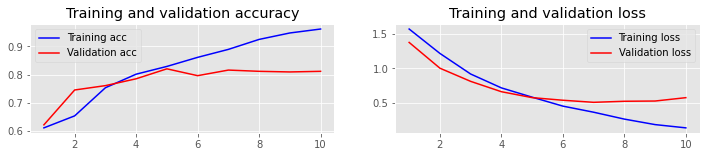

In [62]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 2))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(hist)

## static

In [ ]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten
from tensorflow import keras
import tensorflow as tf 
#CNN architecture -static
print("training CNN ...")
model1 = Sequential()
model1.add(Embedding(nb_words, embed_dim,weights=[embedding_matrix], input_length=maxlen, trainable=False))
#model1.add(Dropout(0.2))

model1.add(Conv1D(64, 2, activation='relu', padding='same'))
model1.add(MaxPooling1D(5))
model1.add(Dropout(0.2))

model1.add(Conv1D(64, 3, activation='relu', padding='same'))
model1.add(MaxPooling1D(5))
model1.add(Dropout(0.2))

model1.add(Conv1D(64, 5, activation='relu', padding='same'))
model1.add(MaxPooling1D(5))
model1.add(Dropout(0.2))

model1.add(Flatten())
#model.add(Dropout(0.4))
#model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0.4))
model1.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model1.add(Dense(1, activation='sigmoid'))  

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy",keras.metrics.Precision(),keras.metrics.Recall()])
model1.summary()

training CNN ...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 183, 100)          2128200   
                                                                 
 conv1d (Conv1D)             (None, 183, 64)           12864     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 36, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 36, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 36, 64)            12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 64)            0         
 1D)                                   

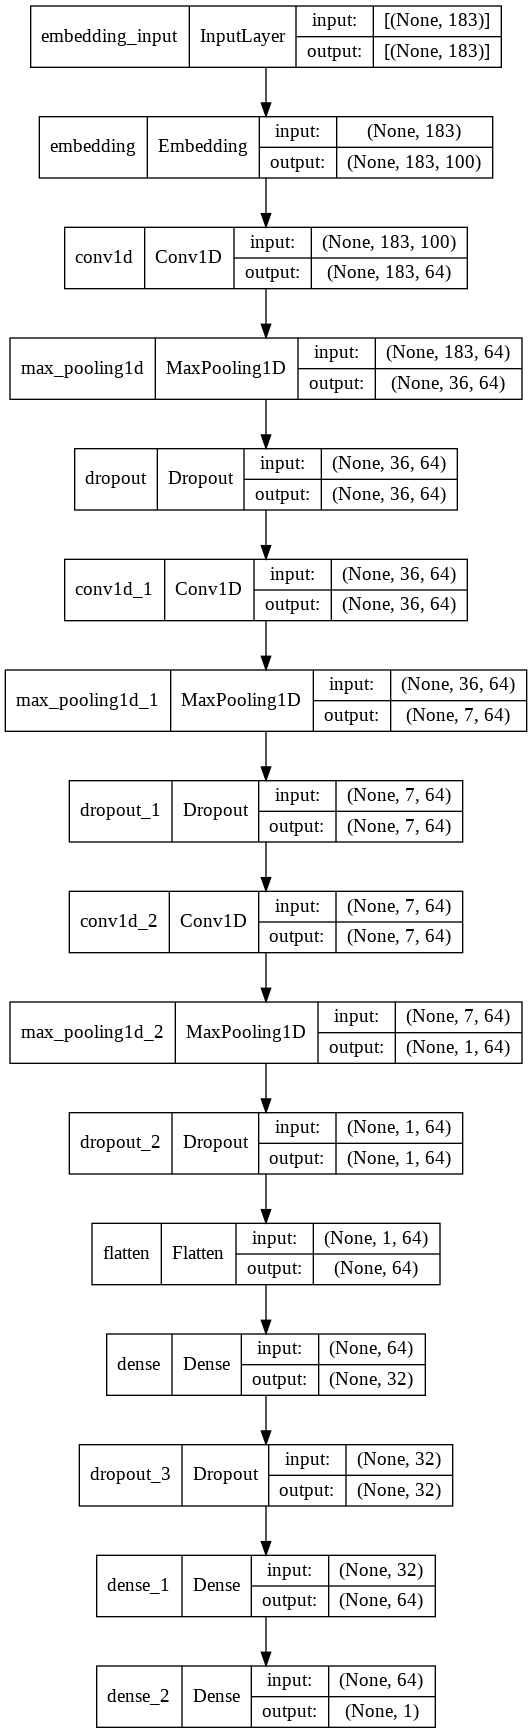

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model1, show_shapes=True, to_file='CNN-Trainable1.png')

In [ ]:
from keras.callbacks import EarlyStopping
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]
#model training
hist1 = model1.fit(X_train, y_train, batch_size=batch_size, epochs=10, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)

Epoch 1/10
32/32 - 3s - loss: 1.5527 - accuracy: 0.6083 - precision_2: 0.4388 - recall_2: 0.1191 - val_loss: 1.3579 - val_accuracy: 0.6208 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - 3s/epoch - 84ms/step
Epoch 2/10
32/32 - 0s - loss: 1.2094 - accuracy: 0.6264 - precision_2: 0.8235 - recall_2: 0.0182 - val_loss: 1.0202 - val_accuracy: 0.7140 - val_precision_2: 0.6615 - val_recall_2: 0.5029 - 267ms/epoch - 8ms/step
Epoch 3/10
32/32 - 0s - loss: 0.9110 - accuracy: 0.7290 - precision_2: 0.6462 - recall_2: 0.6302 - val_loss: 0.7970 - val_accuracy: 0.7494 - val_precision_2: 0.6593 - val_recall_2: 0.7018 - 260ms/epoch - 8ms/step
Epoch 4/10
32/32 - 0s - loss: 0.7434 - accuracy: 0.7596 - precision_2: 0.6673 - recall_2: 0.7298 - val_loss: 0.6712 - val_accuracy: 0.7539 - val_precision_2: 0.6685 - val_recall_2: 0.6959 - 287ms/epoch - 9ms/step
Epoch 5/10
32/32 - 0s - loss: 0.6278 - accuracy: 0.7769 - precision_2: 0.6890 - recall_2: 0.7500 - val_loss: 0.5902 - val_accuracy: 0.7583 - v

In [ ]:
loss, accuracy, precision, recall = model1.evaluate(X_test, y_test, verbose=0)
print('Loss', loss)
print('Accuracy', accuracy)
print('Precision', precision)
print('Recall', recall)

f1_score = (2* recall*precision)/(recall+precision)
print("f1_score", f1_score)

Loss 0.5062659382820129
Accuracy 0.7744227647781372
Precision 0.7010309100151062
Recall 0.6634146571159363
f1_score 0.6817042643529339


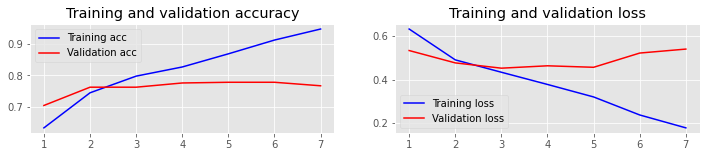

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 2))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(hist1)

## CNN-rand

In [ ]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten
from tensorflow import keras
import tensorflow as tf 
#CNN architecture -static
print("training CNN ...")
model3 = Sequential()
model3.add(Embedding(nb_words, embed_dim, input_length=maxlen, trainable=True))
#model3.add(Dropout(0.2))

model3.add(Conv1D(64, 3, activation='relu', padding='same'))
model3.add(MaxPooling1D(5))
model3.add(Dropout(0.2))

model3.add(Conv1D(64, 3, activation='relu', padding='same'))
model3.add(MaxPooling1D(5))
model3.add(Dropout(0.2))

model3.add(Conv1D(64, 3, activation='relu', padding='same'))
model3.add(MaxPooling1D(5))
model3.add(Dropout(0.2))

model3.add(Flatten())
#model.add(Dropout(0.4))
#model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model3.add(Dense(1, activation='sigmoid'))  

model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy",keras.metrics.Precision(),keras.metrics.Recall()])
model3.summary()

training CNN ...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 366, 100)          2120700   
                                                                 
 conv1d_6 (Conv1D)           (None, 366, 64)           19264     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 73, 64)           0         
 1D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 73, 64)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 73, 64)            12352     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 14, 64)           0         
 1D)                                 

In [ ]:
from keras.callbacks import EarlyStopping
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2, verbose=1)
callbacks_list = [early_stopping]
#model training
hist3 = model3.fit(X_train, y_train, batch_size=batch_size, epochs=5, callbacks=callbacks_list, validation_split=0.2, shuffle=True, verbose=2)

Epoch 1/5
29/29 - 2s - loss: 1.5825 - accuracy: 0.6124 - precision_2: 0.3182 - recall_2: 0.0312 - val_loss: 1.4202 - val_accuracy: 0.6016 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - 2s/epoch - 73ms/step
Epoch 2/5
29/29 - 0s - loss: 1.2931 - accuracy: 0.6258 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 1.1801 - val_accuracy: 0.6016 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - 334ms/epoch - 12ms/step
Epoch 3/5
29/29 - 0s - loss: 1.0566 - accuracy: 0.6258 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.9284 - val_accuracy: 0.6016 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - 330ms/epoch - 11ms/step
Epoch 4/5
29/29 - 0s - loss: 0.7205 - accuracy: 0.7240 - precision_2: 0.8969 - recall_2: 0.2967 - val_loss: 0.7623 - val_accuracy: 0.7392 - val_precision_2: 0.7719 - val_recall_2: 0.4903 - 351ms/epoch - 12ms/step
Epoch 5/5
29/29 - 0s - loss: 0.4918 - accuracy: 0.9525 - precision_2: 0.9482 - recall_2: 0.9236 - val_loss: 0.7

In [ ]:
loss, accuracy, precision, recall = model3.evaluate(X_test, y_test, verbose=0)
print('Loss', loss)
print('Accuracy', accuracy)
print('Precision', precision)
print('Recall', recall)

f1_score = (2* recall*precision)/(recall+precision)
print("f1_score", f1_score)

Loss 0.592464804649353
Accuracy 0.798401415348053
Precision 0.7479674816131592
Recall 0.6731707453727722
f1_score 0.7086007786589645


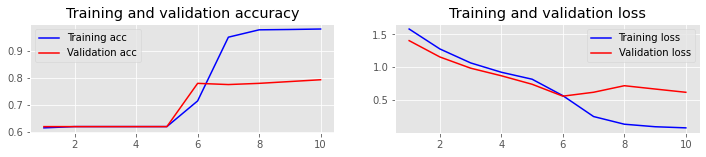

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 2))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(hist3)

## Multi Channel

In [ ]:
import tensorflow as tf 
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding, GlobalMaxPooling1D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate

from tensorflow import keras
import tensorflow as tf 


In [ ]:
from keras.layers import Input

inputs1 = Input(shape=(maxlen,))

# channel 1
embedding1 = Embedding(nb_words, 100, weights=[embedding_matrix],trainable = True)(inputs1)

drop = Dropout(0.2)(embedding1)

conv1 = Conv1D(filters=64, kernel_size=2, activation='relu')(drop)
pool1 = MaxPooling1D(pool_size=5,padding='same')(conv1)
drop1 = Dropout(0.2)(pool1)

conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')(drop1)
pool1 = MaxPooling1D(pool_size=5,padding='same')(conv1)
drop1 = Dropout(0.2)(pool1)

conv1 = Conv1D(filters=64, kernel_size=5, activation='relu')(drop1)
pool1 = MaxPooling1D(pool_size=5,padding='same')(conv1)
drop1 = Dropout(0.2)(pool1)
flat1 = Flatten()(drop1)

In [ ]:
from keras.layers import Input

# channel 2
embedding2 = Embedding(nb_words, 100, weights=[embedding_matrix],trainable = False)(inputs1)

conv2 = Conv1D(filters=64, kernel_size=2, activation='relu')(embedding2)
pool2 = MaxPooling1D(pool_size=5,padding='same')(conv2)
drop2 = Dropout(0.2)(pool2)

conv2 = Conv1D(filters=64, kernel_size=3, activation='relu')(drop2)
pool2 = MaxPooling1D(pool_size=5,padding='same')(conv2)
drop2 = Dropout(0.2)(pool2)

conv2 = Conv1D(filters=64, kernel_size=5, activation='relu')(drop2)
pool2 = MaxPooling1D(pool_size=5,padding='same')(conv2)
drop2 = Dropout(0.2)(pool2)
flat2 = Flatten()(drop2)

In [ ]:
merged = concatenate([flat1, flat2])

# interpretation
dense1 = Dense(32, activation='relu')(merged)
drop2 = Dropout(0.4)(dense1)
#dense1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(drop2)
dense2 = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(weight_decay))(dense1)
outputs = Dense(1, activation='sigmoid')(dense2)

model3 = Model(inputs=inputs1, outputs=outputs)

# compile
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy",keras.metrics.Precision(),keras.metrics.Recall()])
# summarize
print(model3.summary())

#plot_model(model, show_shapes=True, to_file='multichannel.png')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 183)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 183, 100)     2128200     ['input_1[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 183, 100)     0           ['embedding_1[0][0]']            
                                                                                                  
 embedding_2 (Embedding)        (None, 183, 100)     2128200     ['input_1[0][0]']                
                                                                                              

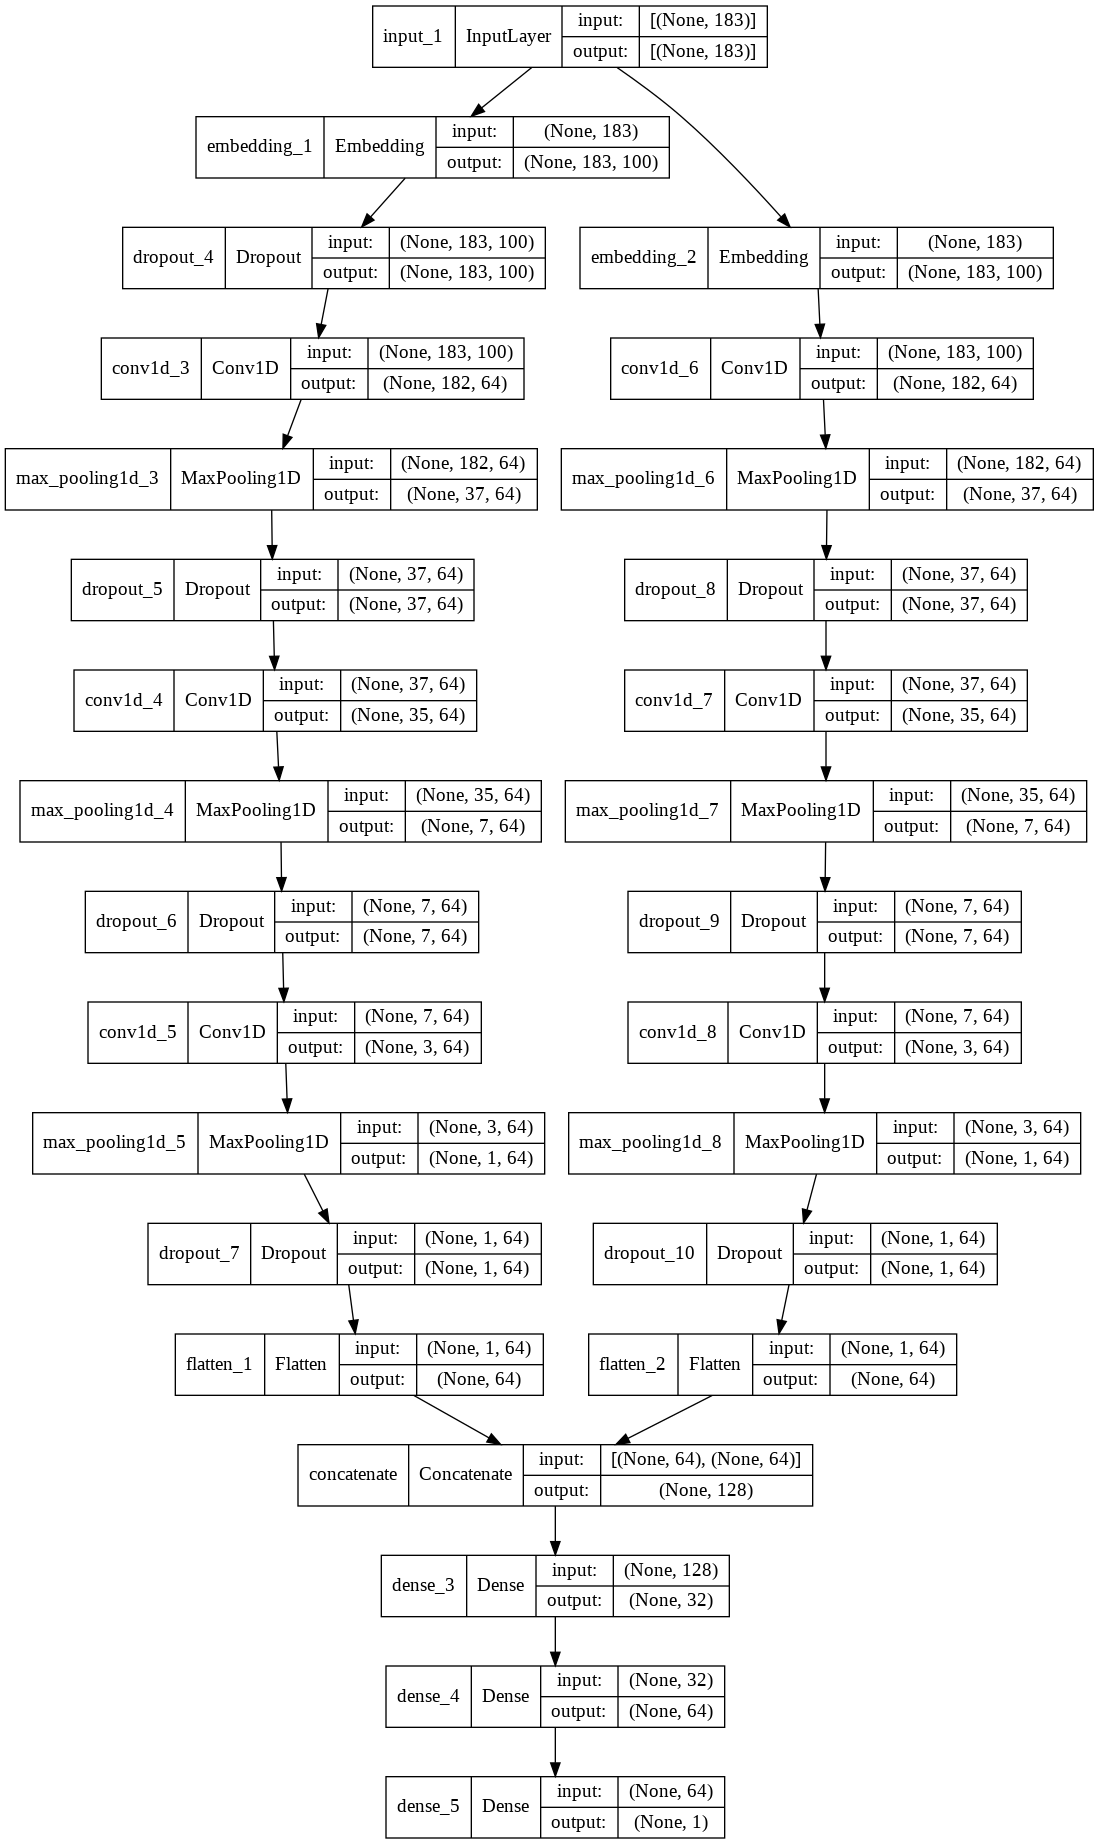

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model3, show_shapes=True, to_file='CNN-Trainable3.png')

In [ ]:
from keras.callbacks import EarlyStopping
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]
#model training
hist3 = model3.fit(X_train, y_train, batch_size=batch_size, epochs=10, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)

Epoch 1/10
32/32 - 3s - loss: 1.4984 - accuracy: 0.6204 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 1.2840 - val_accuracy: 0.6497 - val_precision_2: 0.8095 - val_recall_2: 0.0994 - 3s/epoch - 96ms/step
Epoch 2/10
32/32 - 0s - loss: 1.0947 - accuracy: 0.7056 - precision_2: 0.6629 - recall_2: 0.4544 - val_loss: 0.9630 - val_accuracy: 0.7539 - val_precision_2: 0.7000 - val_recall_2: 0.6140 - 491ms/epoch - 15ms/step
Epoch 3/10
32/32 - 1s - loss: 0.8436 - accuracy: 0.7685 - precision_2: 0.6814 - recall_2: 0.7311 - val_loss: 0.7684 - val_accuracy: 0.7672 - val_precision_2: 0.6854 - val_recall_2: 0.7135 - 530ms/epoch - 17ms/step
Epoch 4/10
32/32 - 0s - loss: 0.6621 - accuracy: 0.8092 - precision_2: 0.7314 - recall_2: 0.7852 - val_loss: 0.6614 - val_accuracy: 0.7761 - val_precision_2: 0.6786 - val_recall_2: 0.7778 - 498ms/epoch - 16ms/step
Epoch 5/10
32/32 - 0s - loss: 0.5302 - accuracy: 0.8430 - precision_2: 0.7870 - recall_2: 0.8034 - val_loss: 0.5806 - val_accuracy: 0.7894 

In [ ]:
loss, accuracy, precision, recall = model3.evaluate(X_test, y_test, verbose=0)
print('Loss', loss)
print('Accuracy', accuracy)
print('Precision', precision)
print('Recall', recall)

f1_score = (2* recall*precision)/(recall+precision)
print("f1_score", f1_score)

Loss 0.6217901706695557
Accuracy 0.7877442240715027
Precision 0.7938144207000732
Recall 0.5634146332740784
f1_score 0.6590584830420592


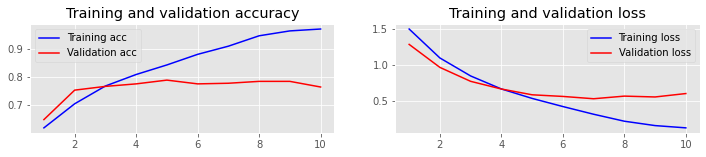

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 2))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(hist3)